<a href="https://colab.research.google.com/github/Eason0227/Kaggle-competition-tabular-playground-series-jul-2022/blob/main/tabular_playground_series_jul_2022_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tabular-playground-series-jul-2022
https://www.kaggle.com/competitions/tabular-playground-series-jul-2022/overview  
Evaluation：Evaluating the Adjusted Rand Index between the ground truth cluster labels of the data and predicted cluster labels.
### refernce
https://www.kaggle.com/code/cabaxiom/tps-jul-22-bgmm-semi-supervised#Feature-Importance  
https://www.kaggle.com/code/mehrankazeminia/3-3-tps22jul-clustering-ensembling

### Bayesian Gaussian Mixture Models - Semi-Supervised
Contents  
* EDA
* Determine the optimal number of clusters using GMM and BIC scores
* Estimate Feature importance
* Cluster the data using soft-voting
* Classification using the confident predictions from clustering as training labels
* Iterative Classification with BGMM Classifier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
    
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklego.mixture import BayesianGMMClassifier

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tabular playground series jul 2022/data.csv")
submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tabular playground series jul 2022/sample_submission.csv")

In [ ]:
pip install sklego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=b098ce10dd98c44157765fb96e3c69dfdf54fad7ed55d7921fb6aada77cda3bb
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=d87723a41c6aa02183b766a84221965922d2621b891129dfe9df5ee3aa50564c
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98000 entries, 0 to 97999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      98000 non-null  int64  
 1   f_00    98000 non-null  float64
 2   f_01    98000 non-null  float64
 3   f_02    98000 non-null  float64
 4   f_03    98000 non-null  float64
 5   f_04    98000 non-null  float64
 6   f_05    98000 non-null  float64
 7   f_06    98000 non-null  float64
 8   f_07    98000 non-null  int64  
 9   f_08    98000 non-null  int64  
 10  f_09    98000 non-null  int64  
 11  f_10    98000 non-null  int64  
 12  f_11    98000 non-null  int64  
 13  f_12    98000 non-null  int64  
 14  f_13    98000 non-null  int64  
 15  f_14    98000 non-null  float64
 16  f_15    98000 non-null  float64
 17  f_16    98000 non-null  float64
 18  f_17    98000 non-null  float64
 19  f_18    98000 non-null  float64
 20  f_19    98000 non-null  float64
 21  f_20    98000 non-null  float64
 22

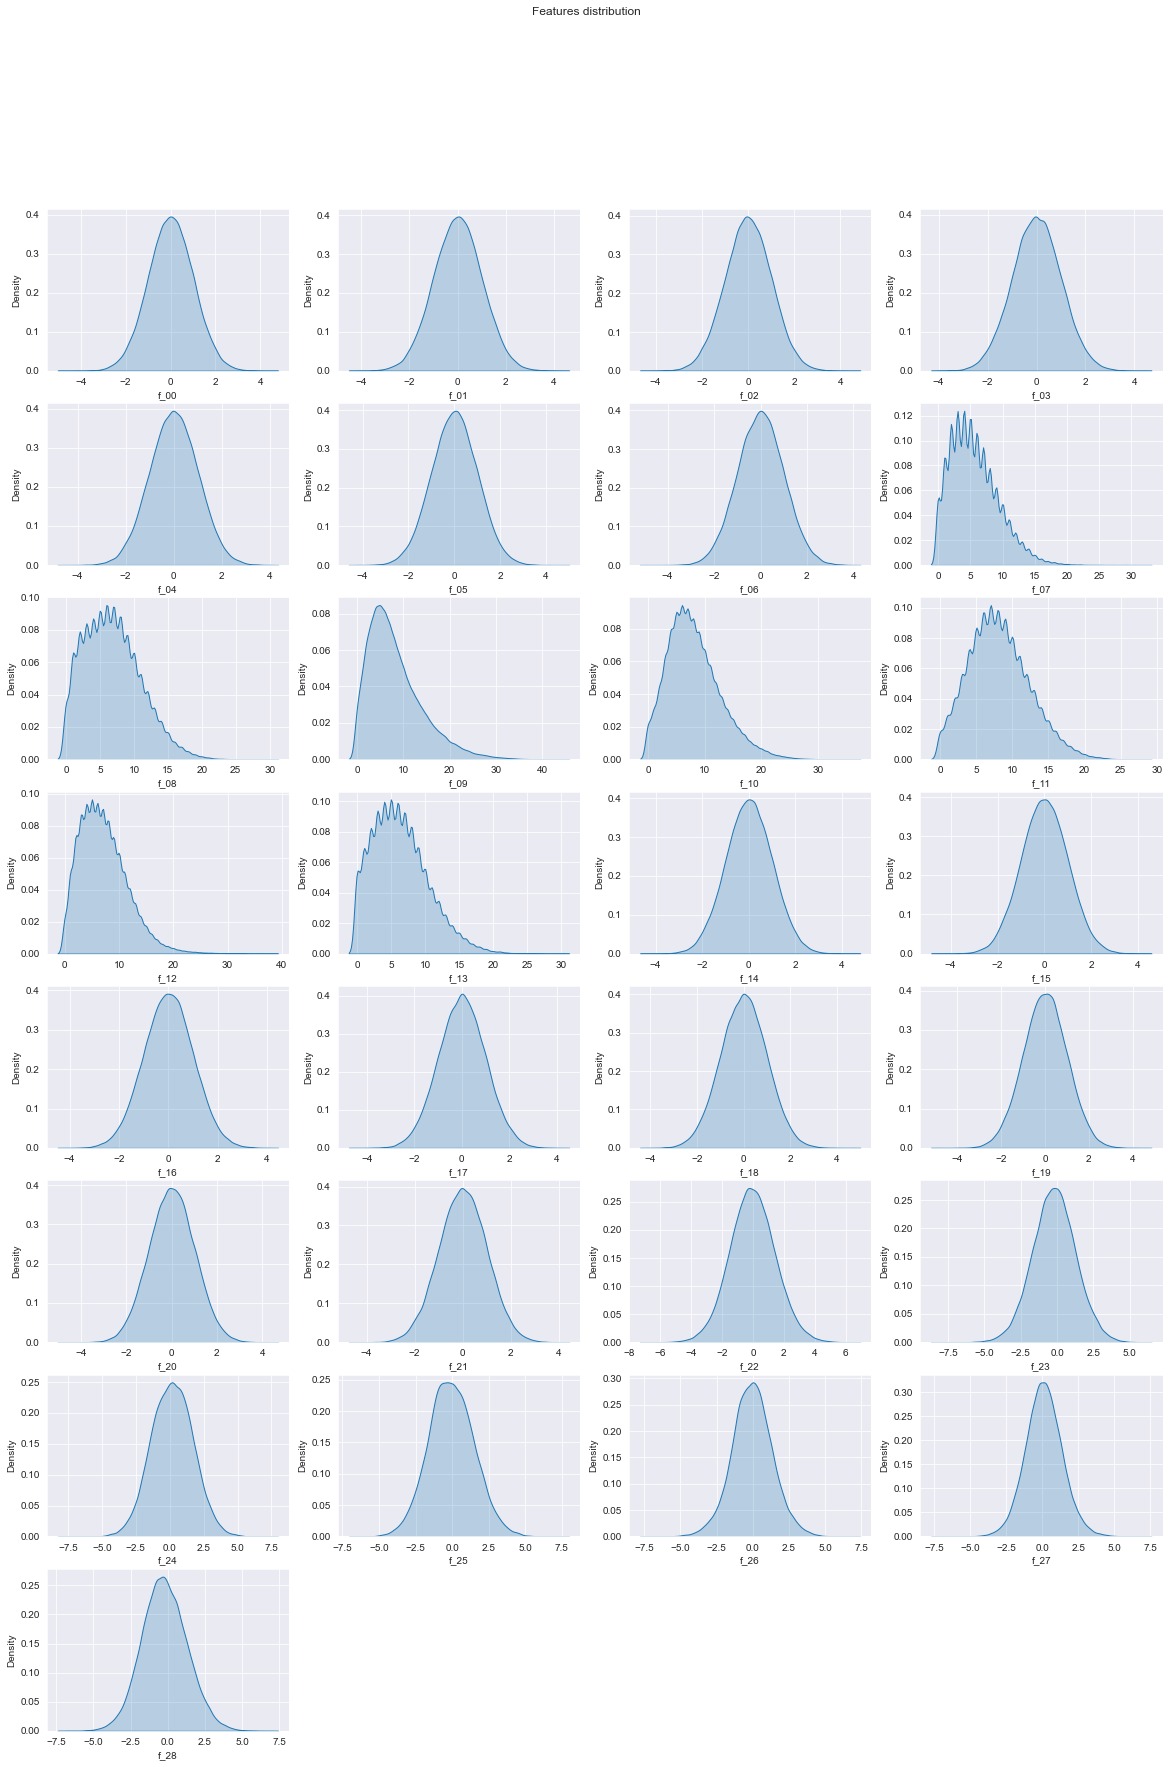

In [ ]:
cols = list(df.columns[1:-1])

plt.figure(figsize=(20,28))
for index,col in enumerate(cols):
    plt.subplot(8,4,index+1)
    sns.kdeplot(x = df[col],shade="fill")
plt.suptitle("Features distribution")
plt.show()

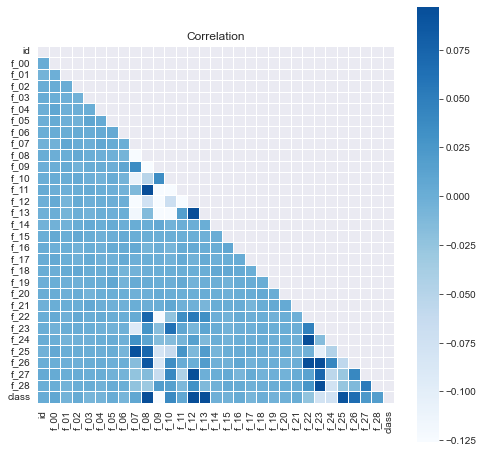

In [ ]:
plt.figure(figsize=(8,8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)) 
sns.heatmap(corr, mask=mask, robust=True, center=0,square=True, linewidths=.6,cmap='Blues')
plt.title('Correlation')
plt.show()

### Power Transformer
Apply a power transform featurewise to make data more Gaussian-like.  
This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.  
‘yeo-johnson’, works with positive and negative values.  
‘box-cox’, only works with strictly positive values  

In [ ]:
transformer = PowerTransformer()
X_scaled = transformer.fit_transform(df)
X_scaled = pd.DataFrame(X_scaled, columns = df.columns)

### Optimal Number of Clusters
* Find the optimal number of clusters using a Gaussian Mixture Model.
* Using the Bayesian Information Criterion (BIC), The goal is to minimise the BIC score.

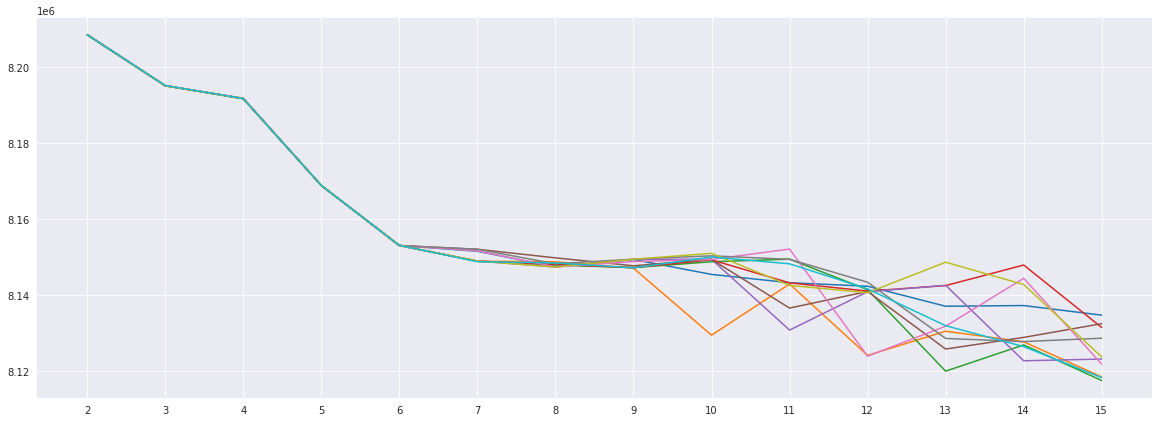

In [ ]:
def components_number_multiple(max_n, n_seeds):
    bic_scores = []
    for n in range(2,max_n):
        bic_scores_n = []
        for seed in range(n_seeds):
            gmm = GaussianMixture(n_components=n, covariance_type = 'full', n_init=3, random_state=seed)
            gmm.fit(X_scaled)
            bic_scores_n.append(gmm.bic(X_scaled))
        bic_scores.append(bic_scores_n)
    return bic_scores

def plot_components_number_multiple(max_n, n_seeds):
    bic_scores = components_number_multiple(max_n + 1, n_seeds)
    bic_df = pd.DataFrame(data = bic_scores).T
    bic_df.columns = range(2,max_n+1)
    f,ax = plt.subplots(figsize=(20,7))
    for i in range(n_seeds):
        sns.lineplot(x=bic_df.columns, y=bic_df.loc[i].values)
    ax.set_xticks(range(2,max_n+1))
    
    return bic_df

a = plot_components_number_multiple(max_n = 15, n_seeds = 10)

* Find the optimal number of clusters using a SOM neurual network.
* Using topology map to determine the number of clusters

In [ ]:
def plot_topology(output_layer,size):
  num = 0
  xdata,ydata = [],[]
  for i in range(size):
    xxdata , yydata = [],[]
    for j in range(size):
      xxdata.append(j)
      yydata.append(num)
    num += 1
    xdata.append(xxdata)
    ydata.append(yydata)
  X,Y,Z = xdata,ydata,output_layer
  fig = plt.figure(figsize=(7,8))
  ax3d = plt.axes(projection="3d")
  xx = np.array(X).reshape(size*size)
  yy = np.array(Y).reshape(size*size)
  zz = np.array(Z).reshape(size*size)
  ax3d.plot_trisurf(xx, yy, zz, cmap = 'viridis')
  ax3d.set_title('output layer')
  ax3d.set_xlabel('X')
  ax3d.set_ylabel('Y')
  ax3d.set_zlabel('Z')
  plt.show()

In [ ]:
pip install minisom

[[    0.     0. 15711.     0.     0.     0. 12694.]
 [    0.     0.     0.     0.     0.     0.     0.]
 [13061.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0.     0.     0.     0. 14195.]
 [    0.     0.     0.     0.     0.     0.     0.]
 [14370.     0.     0.     0.     0.     0.     0.]
 [    0.     0.     0. 17190.     0.     0. 10779.]]


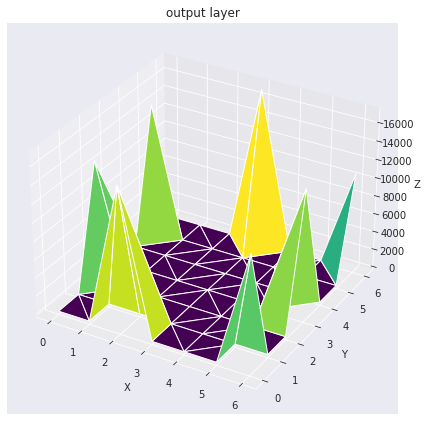

In [ ]:
from minisom import MiniSom
x = np.array(X_scaled.drop(['id'],axis = 1) )
size = 7
som = MiniSom(x = size, y = size, input_len=29, sigma=1 ,learning_rate=0.5,neighborhood_function='mexican_hat')
som.train(x,700)
frequencies=np.zeros((size,size))
for position,values in som.win_map(x).items():
  frequencies[position[0],position[1]]=len(values)
print(frequencies)
plot_topology(frequencies,size = size)

### Finally, Using 7 as the number of clusters. 

### Feature Importance


In [ ]:
bgmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full', n_init=3, random_state=42,max_iter=1000)
predicted_class = bgmm.fit_predict(X_scaled)
df["class"] = predicted_class

In [ ]:
cols_select = []
alpha = 0.05

for col in df.columns[1:-1]:
    stat, p_value = shapiro(df[col])
    if (p_value <= alpha): 
        cols_select.append(col)       
print(cols_select)  

/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']


In [ ]:
best_cols = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']

## Unsupervosed learning- Clustering

### Evaluate clustering performance 
* Silhoutte Coefficient  
The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.  
The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

* Calinski-Harabasz Index  
The score is higher when clusters are dense and well separated


* Davies-Bouldin Index  
Lower Davies-Bouldin index relates to a model with better separation between the cluster

In [ ]:
def score_clusters(X, predictions, silhouette = True, verbose=False):

    db_score = davies_bouldin_score(X=X, labels=predictions)
    ch_score = calinski_harabasz_score(X=X, labels=predictions)
    s_score = silhouette_score(X=X, labels=predictions, metric='euclidean')
    
    if verbose:
        print("David Bouldin score: {0:0.4f}".format(db_score))
        print("Calinski Harabasz score: {0:0.3f}".format(ch_score))
        print("Silhouette score: {0:0.4f}".format(s_score))
    return db_score, ch_score, s_score

###  soft voting
Gausian Mixture Models can output probabilities, so we fit the model multiple times with different random seeds and sum the predicted probabilities. The class with the highest predicted probability will then be use for the final class assignment.

The main challenge in implementing this is each time that we fit the model, the model will output different cluster labels. To get around this we calculate the distance between between the cluster centroids from the first model and the cluster centroids of each subsequently fitted model. The cluster centroid of a class will be in a similar locations each time the model is fit, even though the randomly assigned label for that cluster may be different. We can use this info to ensure we are consistent with the cluster label assignments from the first fitted model. This is not a perfect solution, as it relies on the cluster centroids being in similar locations for each (B)GMM fit, but it seems sufficient.

In [ ]:
def soft_voting(predict_number, best_cols = best_cols):
    #initialise dataframe with 0's
    predicted_probabilities = pd.DataFrame(np.zeros((len(df),7)), columns=range(1,8))
    # loop with a different random seeds
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = X_scaled.sample(40000)
        gmm = BayesianGaussianMixture(n_components=7, covariance_type = 'full',
                                      weight_concentration_prior_type="dirichlet_distribution", max_iter=300, init_params="kmeans", n_init=3, random_state=i)
        gmm.fit(X_scaled_sample[best_cols])
        pred_probs = gmm.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # ensuring clusters are labeled the same value at each fit
        if i == 0: #起始的分群中心點
            initial_centers = gmm.means_
        new_classes = []
        for mean2 in gmm.means_:  #對於目前gmm的中心，找到初始gmm中心與於目前中心的線性距離
            distances = [np.linalg.norm(mean1-mean2) for mean1 in initial_centers]
            # select the class with the minimum distance
            new_class = np.argmin(distances) + 1 #add 1 as our labels are 1-7 but index is 0-6
            new_classes.append(new_class)
        # if the mapping from old cluster labels to new cluster labels isn't 1 to 1
        if len(new_classes) != len(set(new_classes)):
            print("iteration", i, "could not determine the cluster label mapping, skipping")
            continue
        #apply the mapping by renaming the dataframe columns representing the original labels to the new labels    
        pred_probs = pred_probs.rename(columns=dict(zip(range(1,8),new_classes)))
        
        #add the current prediction probabilities to the overall prediction probabilities
        predicted_probabilities = predicted_probabilities + pred_probs
        # lets score the cluster labels each iteration to see if soft voting is helpful
        score_clusters(X_scaled[best_cols], predicted_probabilities.idxmax(axis=1), verbose=True)
    
    #normalise dataframe so each row sums to 1
    predicted_probabilities = predicted_probabilities.div(predicted_probabilities.sum(axis=1), axis=0)
    return predicted_probabilities

In [ ]:
pred_probs = soft_voting(10)

========= 0 ==========
David Bouldin score: 3.6004
Calinski Harabasz score: 3814.665
Silhouette score: 0.0358
========= 1 ==========
David Bouldin score: 3.6185
Calinski Harabasz score: 3801.415
Silhouette score: 0.0354
========= 2 ==========
David Bouldin score: 3.6100
Calinski Harabasz score: 3807.611
Silhouette score: 0.0357
========= 3 ==========
iteration 3 could not determine the cluster label mapping, skipping
========= 4 ==========
David Bouldin score: 3.6052
Calinski Harabasz score: 3810.460
Silhouette score: 0.0357
========= 5 ==========
David Bouldin score: 3.6045
Calinski Harabasz score: 3810.442
Silhouette score: 0.0358
========= 6 ==========
David Bouldin score: 3.6078
Calinski Harabasz score: 3810.371
Silhouette score: 0.0358
========= 7 ==========
David Bouldin score: 3.6064
Calinski Harabasz score: 3810.468
Silhouette score: 0.0358
========= 8 ==========
David Bouldin score: 3.6070
Calinski Harabasz score: 3811.188
Silhouette score: 0.0358
========= 9 ==========
David 

In [ ]:
score_clusters(X_scaled[best_cols],pred_probs.idxmax(axis=1), verbose=True)

David Bouldin score: 3.6073
Calinski Harabasz score: 3811.341
Silhouette score: 0.0358


(3.6073349973362596, 3811.341346319397, 0.03579633713684637)

In [ ]:
def best_class(df):
    new_df = df.copy()
    new_df["highest_prob"] = df.max(axis=1)
    new_df["best_class"] = df.idxmax(axis=1)
    new_df["second_highest_prob"] = df.apply(lambda x: x.nlargest(2).values[-1], axis=1)
    new_df["second_best_class"] = df.apply(lambda x: np.where(x == x.nlargest(2).values[-1])[0][0]+1, axis=1)
    return new_df

In [ ]:
cluster_class_probs = best_class(pred_probs)
cluster_class_probs.head()

,1,2,3,4,5,6,7,highest_prob,best_class,second_highest_prob,second_best_class
0,0.003654,0.011138,0.003130,0.979133,4.566098e-07,0.002444,0.000501,0.979133,4,0.011138,2
1,0.000011,0.934430,0.019311,0.000331,1.559131e-02,0.026777,0.003549,0.934430,2,0.026777,6
2,0.203234,0.000356,0.000095,0.794973,1.001970e-08,0.000017,0.001325,0.794973,4,0.203234,1
3,0.089156,0.014756,0.000050,0.000022,8.587370e-01,0.010507,0.026772,0.858737,5,0.089156,1
4,0.000008,0.017036,0.000143,0.000005,8.629409e-07,0.000002,0.982804,0.982804,7,0.017036,2


### Supervised learning - Classification
* Adopting a semi-supervised approach for clustering
* We fit our classification model using points the clustering algorithm was confident that it got correct.
* We use the classification model to predict the points it was not confident that it got correct.
* The hope is that the classification algorithm is better than the clustering algorithm. If this is true we can trust the classification algorithms predictions more than the clustering algorithms predictions and improve our score. 

In [ ]:
confident_predictions = cluster_class_probs.loc[cluster_class_probs["highest_prob"] >= 0.8] #只取最高機率大於0.8的資料，共62270筆資料
X_scaled["class"] = confident_predictions["best_class"] #將分群結果加入原始資料集作為Label 

In [ ]:
X_scaled.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,class
0,-2.196170,-0.389230,-0.917652,0.647948,0.590717,-0.824836,0.734685,2.259470,-0.977987,1.383372,...,-0.753925,-0.763110,-0.707876,0.911477,-0.678852,0.768543,0.960344,1.042536,0.694234,4.0
1,-2.195469,-0.688368,-0.458647,0.653182,0.995359,-1.644030,0.864898,-0.085604,-0.977987,-0.875405,...,-0.088164,-1.777545,-0.535582,0.453824,1.031505,-0.117686,-0.550783,0.367242,-1.636652,2.0
2,-2.194869,0.805709,0.319397,-1.166935,-0.622421,0.108371,0.785018,1.990489,0.021718,1.017648,...,-1.598612,1.194423,2.203065,0.086974,-1.519163,-0.568662,0.978900,-0.926277,-2.296373,NaN
3,-2.194325,-0.500469,0.223997,0.262677,0.234061,0.417047,-1.218768,0.144455,0.286548,-1.213526,...,1.283827,0.532884,0.731623,-1.218086,0.826492,-1.173592,-0.395085,-0.100021,0.326682,5.0
4,-2.193820,-0.670427,-1.044482,-0.270854,-1.833338,-0.285955,-1.849243,0.787627,0.756900,0.187543,...,-0.432406,0.321899,0.228337,-1.482684,0.847999,-0.613935,1.164389,-0.374203,-1.160058,7.0


In [ ]:
# 以class label是否包含類別去切分訓練、測試資料
# 以比較有信心的分群資料作為訓練，信心低的作為測試
train_df = X_scaled.loc[X_scaled["class"] == X_scaled["class"]] 
test_df = X_scaled.loc[X_scaled["class"] != X_scaled["class"]] 

In [ ]:
X = train_df.drop(["class"],axis=1).reset_index(drop=True)
y = train_df["class"].reset_index(drop=True)

X_test = test_df.drop(["class"],axis=1).reset_index(drop=True)
X_full = X_scaled.drop(["class"],axis=1)

## Model
Using 5 model

In [ ]:
model_et = ExtraTreesClassifier(n_estimators = 2000,n_jobs = -1,random_state=42)
model_lgbm = LGBMClassifier(objective = 'multiclass',n_estimators = 10000,random_state = 42,learning_rate = 0.1,n_jobs = -1)
model_qda = QuadraticDiscriminantAnalysis()
model_lda = LinearDiscriminantAnalysis()
model_bgmm = BayesianGMMClassifier(n_components=7,random_state = 42,tol =1e-3,covariance_type = 'full',max_iter = 1000,n_init=4,init_params='kmeans')
models = {"ET":model_et, "LGBM":model_lgbm, "QDA":model_qda, "LDA":model_lda, "BGMM_C":model_bgmm}                               

### Cross validation
check the performance of classification algorithms 

In [ ]:
def k_fold_cv(model,X,y, verbose=True):
    kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 0)

    feature_imp, y_pred_list, y_true_list, acc_list  = [],[],[],[]
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        if verbose: print("==fold==", fold)
        X_train = X.loc[train_index]
        X_val = X.loc[val_index]

        y_train = y.loc[train_index]
        y_val = y.loc[val_index]

        model.fit(X_train,y_train)

        y_pred = model.predict(X_val)

        y_pred_list = np.append(y_pred_list, y_pred)
        y_true_list = np.append(y_true_list, y_val)

        acc_list.append(accuracy_score(y_pred, y_val))
        if verbose: print('Acc', accuracy_score(y_pred, y_val))

        try:
            feature_imp.append(model.feature_importances_)
        except AttributeError: # if model does not have .feature_importances_ attribute
            pass # returns empty list
            
    return feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val

### Evaluate performance of models 

In [ ]:
def evaluate_models():
    for model_name, model in models.items():
        print("===",model_name,"===")
        feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=model,X=X,y=y, verbose=False)
        acc_score = accuracy_score(y_pred_list, y_true_list)
        print("{0:0.4f}".format(acc_score))

In [ ]:
evaluate_models()

=== ET ===
0.9798
=== LGBM ===
0.9957
=== QDA ===
0.9998
=== LDA ===
0.8456
=== BGMM_C ===
0.9882


### Choose the best model : LGBM

In [ ]:
feature_imp, y_pred_list, y_true_list, acc_list, X_val, y_val = k_fold_cv(model=model_lgbm,X=X,y=y)

==fold== 0
Acc 0.9956643918105179
==fold== 1
Acc 0.9959052589321558
==fold== 2
Acc 0.995262946607788
==fold== 3
Acc 0.9956643918105179
==fold== 4
Acc 0.9957446808510638


In [ ]:
feature_imp

[array([ 4237,  3613,  4080,  4899,  3641,  3718,  3817,  2969,  8759,
         8217, 10043,  9005,  7930,  8997,  8339,  2929,  3883,  4245,
         3739,  3687,  3820,  2628,  3499, 10477,  9565,  8788,  9584,
         9481,  8695,  8922], dtype=int32),
 array([ 3393,  3245,  4102,  4179,  3589,  4927,  3663,  3509,  8812,
         8492, 10250,  8963,  7980,  8916,  8287,  3887,  4122,  3862,
         3544,  3621,  4179,  2897,  4012,  9281,  9610,  8353,  9268,
         9801,  8451,  9265], dtype=int32),
 array([ 3284,  2660,  3474,  4181,  4207,  3881,  3585,  3647,  8557,
         8455, 10131,  9097,  7501,  8929,  8380,  3642,  3659,  3692,
         2818,  3976,  4135,  3425,  3490,  9994,  9417,  9810,  9879,
         9829,  8632,  8970], dtype=int32),
 array([ 4289,  3104,  3768,  4466,  3098,  3555,  3419,  3189,  8567,
         8337, 10390,  8826,  7972,  8950,  8011,  3406,  2950,  4815,
         3645,  3761,  4339,  3526,  2764,  9440, 10361,  8891,  9641,
         9447,  

### Feature importance
Confirm the features we dropped in the clustering algorithm are also not important for the classification algorithm.

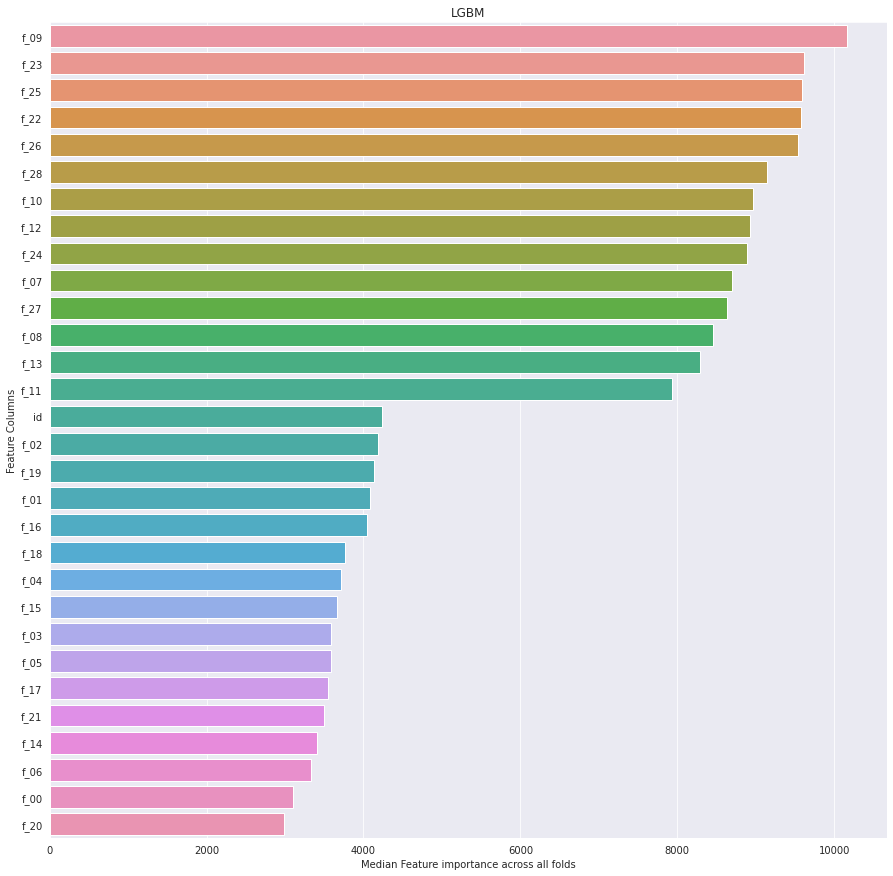

In [ ]:
def fold_feature_importances(model_importances, column_names, model_name, n_folds):
  importances_df = pd.DataFrame({"feature_cols": column_names })
  for i in range(n_folds):
    importances_df["importances_fold_"+str(i+1)] = model_importances[i]
  importances_df["importances_fold_median"] = importances_df.drop(columns=["feature_cols"]).median(axis=1)
  importances_df = importances_df.sort_values(by="importances_fold_median", ascending=False)

  f, ax = plt.subplots(figsize=(15, 15))
  ax = sns.barplot(data = importances_df, x = "importances_fold_median", y="feature_cols")
  ax.set_xlabel("Median Feature importance across all folds")
  ax.set_ylabel("Feature Columns")
  plt.title(model_name)

fold_feature_importances(model_importances=feature_imp,column_names=X_val.columns,model_name="LGBM",n_folds=5)

As expected, [f_07, f_08, ..., f_13] and [f_22, f_23, ... , f_28] seem important, but the other features do not.

### Inference
use all model predict the cluster label and evaluate result

In [ ]:
def fit_predict_all():
    predictions = []
    model_names = []
    scores = []
    for model_name, model in models.items():
        print("===",model_name,"===")
        model.fit(X[best_cols], y) # fit training data 
        preds_prob =  model.predict_proba(X_full[best_cols]) # predict all data and get its prediction probility
        preds_prob_df = pd.DataFrame(preds_prob, columns=range(1,8), index=X_scaled.index)
        db, ch, s = score_clusters(X_scaled[best_cols], preds_prob_df.idxmax(axis=1), verbose=True) # evaluate result
        scores.append((db,ch,s))
        predictions.append(preds_prob_df)
        model_names.append(model_name)
    
    return predictions, model_names, scores
    
predictions, model_names, scores = fit_predict_all()

=== ET ===
David Bouldin score: 3.4291
Calinski Harabasz score: 3988.111
Silhouette score: 0.0411
=== LGBM ===
David Bouldin score: 3.5627
Calinski Harabasz score: 3880.284
Silhouette score: 0.0374
=== QDA ===
David Bouldin score: 3.5168
Calinski Harabasz score: 3901.517
Silhouette score: 0.0385
=== LDA ===
David Bouldin score: 3.0199
Calinski Harabasz score: 4653.890
Silhouette score: 0.0561
=== BGMM_C ===
David Bouldin score: 3.6052
Calinski Harabasz score: 3823.773
Silhouette score: 0.0356


Lets compare these scores to our clustering scores and also add our clustering predictions to the list of classification predictions

In [ ]:
cluster_class_probs = cluster_class_probs.loc[:,[1,2,3,4,5,6,7]]

In [ ]:
predictions.append(cluster_class_probs) #將原分群的預測機率加入模型的預測機率
model_names.append("BGMM") #分群模型BGMM

In [ ]:
db, ch, s = score_clusters(X_scaled[best_cols], cluster_class_probs.idxmax(axis=1), verbose=True)
scores.append((db,ch,s))

David Bouldin score: 3.6274
Calinski Harabasz score: 3804.007
Silhouette score: 0.0355


Our classification algorithm appears to be performing better than our clustering algorithms; although I don't trust the clustering scores too much.

### Combine Predictions
combine the probabilities from the different classification/clustering algorithms.

In [ ]:
#chosen fairly randomly
predictions_df = 0.5 * predictions[0] + 1.5 * predictions[1] + 0.5 * predictions[2] + 1.5 * predictions[4] + 0.5 * predictions[5]

#normalise so rows sums to 1
predictions_df = predictions_df.div(predictions_df.sum(axis=1), axis=0)
predictions_df = best_class(predictions_df)


In [ ]:
db, ch, s = score_clusters(X_scaled[best_cols], predictions_df["best_class"], verbose=True)
scores.append((db,ch,s))
model_names.append("combined")

David Bouldin score: 3.5488
Calinski Harabasz score: 3893.094
Silhouette score: 0.0377


In [ ]:
pd.DataFrame(scores, index=model_names, columns=["Davies-Bouldin Index","Calinski-Harabasz Index","Silhouette Coefficient"])

,Davies-Bouldin Index,Calinski-Harabasz Index,Silhouette Coefficient
ET,3.429108,3988.111041,0.041097
LGBM,3.562729,3880.283559,0.037445
QDA,3.516778,3901.517321,0.038468
LDA,3.019943,4653.889971,0.056131
BGMM_C,3.605247,3823.773435,0.035554
BGMM,3.627421,3804.007284,0.035539
combined,3.548768,3893.093995,0.037731


### Iterative Classification - BGMM Classifier¶
To improve performance further we can iteratively use the the predicted labels from the previous iteration's model as our training labels for the current iteration's model.

In [ ]:
def update_predictions(predict_number, y):
    for i in range(predict_number):
        print("=========", i, "==========")
        X_scaled_sample = X_scaled.sample(50000)
        y_sample = y.loc[X_scaled_sample.index]
        
        bgmmC = BayesianGMMClassifier(n_components=7,random_state = i,tol =1e-3,covariance_type = 'full',max_iter = 300,n_init=3,init_params='kmeans')
        
        bgmmC.fit(X_scaled_sample[best_cols], y_sample)
        
        pred_probs = bgmmC.predict_proba(X_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))
        
        # lets score the cluster labels each iteration
        score_clusters(X_scaled[best_cols], pred_probs.idxmax(axis=1), verbose=True)
        y = pred_probs.idxmax(axis=1)
        
    return pred_probs

In [ ]:
predicted_probabilities = update_predictions(predict_number=20, y=predictions_df["best_class"])

========= 0 ==========
David Bouldin score: 3.6254
Calinski Harabasz score: 3784.440
Silhouette score: 0.0344
========= 1 ==========
David Bouldin score: 3.6851
Calinski Harabasz score: 3699.559
Silhouette score: 0.0324
========= 2 ==========
David Bouldin score: 3.7386
Calinski Harabasz score: 3644.513
Silhouette score: 0.0313
========= 3 ==========
David Bouldin score: 3.7755
Calinski Harabasz score: 3606.856
Silhouette score: 0.0306
========= 4 ==========
David Bouldin score: 3.8094
Calinski Harabasz score: 3581.096
Silhouette score: 0.0302
========= 5 ==========
David Bouldin score: 3.8307
Calinski Harabasz score: 3563.320
Silhouette score: 0.0300
========= 6 ==========
David Bouldin score: 3.8463
Calinski Harabasz score: 3552.723
Silhouette score: 0.0298
========= 7 ==========
David Bouldin score: 3.8534
Calinski Harabasz score: 3550.081
Silhouette score: 0.0298
========= 8 ==========
David Bouldin score: 3.8522
Calinski Harabasz score: 3547.736
Silhouette score: 0.0297
========= 

In [ ]:
predictions_df = best_class(predicted_probabilities)

In [ ]:
predictions_df.head()

,1,2,3,4,5,6,7,highest_prob,best_class,second_highest_prob,second_best_class
0,1.118847e-03,9.930009e-01,5.829370e-03,0.000002,1.053539e-05,3.728590e-09,3.809276e-05,0.993001,2,0.005829,3
1,9.130823e-04,8.472699e-05,1.551144e-07,0.000444,1.553775e-04,2.894429e-03,9.955077e-01,0.995508,7,0.002894,6
2,4.107009e-07,5.566534e-02,9.443124e-01,0.000022,3.699887e-21,6.729751e-13,4.006938e-26,0.944312,3,0.055665,2
3,3.056485e-08,8.563957e-07,8.960118e-04,0.002391,3.592112e-08,9.963793e-01,3.331962e-04,0.996379,6,0.002391,4
4,2.121894e-04,1.345387e-07,5.010801e-07,0.999636,1.509247e-04,8.373580e-09,1.285245e-10,0.999636,4,0.000212,1


### Submission

In [ ]:
submission["Predicted"] = predictions_df["best_class"]
submission.to_csv('submission_1.csv', index=False)

In [ ]:
submission

,Id,Predicted
0,0,2
1,1,7
2,2,3
3,3,6
4,4,4
...,...,...
97995,97995,7
97996,97996,5
97997,97997,3
97998,97998,1
